# The mission:
#### Multi classification of news posts into categories (politics, wellness, travels etc).
#### we will use a news data set, TF-IDF vectorization, and naive bayes model.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction, model_selection, pipeline, preprocessing
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
# this is a function from gensim libarary which apply list of chosen filters to a string.
from gensim.parsing.preprocessing import preprocess_string

# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline


In [2]:
np.random.seed(42)
sns.set_theme(style="darkgrid")

**Loading the json file**

In [3]:
lst_dics = []
with open('/kaggle/input/news-category-dataset/News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

**Create pandas df and observe it:**

In [4]:
## create dtf
df = pd.DataFrame(lst_dics)
df.sample(10)

,category,headline,authors,link,short_description,date
56274,CRIME,Shooting Rampage Results In 'Mass Casualties' ...,,https://www.huffingtonpost.com/entry/shooting-...,"ORLANDO, Fla., June 12 (Reuters) - A gunman ki...",2016-06-12
9929,POLITICS,"Donald Trump Lashes Out At CNN, ABC Over Repor...",Mollie Reilly,https://www.huffingtonpost.com/entry/donald-tr...,"The president criticized the ""fake news media""...",2017-12-09
163271,STYLE & BEAUTY,Model Kate Moss Walks Louis Vuitton RTW Fall 2013,"Catherine Garvin, Contributor\nWriter, Author,...",https://www.huffingtonpost.com/entry/model-kat...,Golden girl model Kate Moss wowed in her usual...,2013-03-07
190013,DIVORCE,7 Ways Single Moms Cope With Loneliness,,https://www.huffingtonpost.comhttp://www.circl...,“Am I the only single mom feeling lonely out t...,2012-05-24
13564,POLITICS,Sen. Sherrod Brown: Steve Bannon 'Is A White S...,Igor Bobic,https://www.huffingtonpost.com/entry/steve-ban...,"Echoing comments by Rep. Frederica Wilson, he ...",2017-10-22
87545,BUSINESS,eBay Bans Confederate Flags,,https://www.huffingtonpost.com/entry/ebay-conf...,"The website called it a ""symbol of divisivenes...",2015-06-23
90378,BLACK VOICES,The Roots Aim To Expand Music Festival Followi...,Brennan Williams,https://www.huffingtonpost.com/entry/the-8th-a...,,2015-05-22
118034,SPORTS,Derek Jeter Fakes Out Opponent To Start Double...,Michael Klopman,https://www.huffingtonpost.com/entry/derek-jet...,,2014-07-08
40362,QUEER VOICES,Brazilian Squatters Offer Shelter From Anti-LG...,"Nacho Doce, Reuters",https://www.huffingtonpost.com/entry/brazil-an...,“It’s not my fault that I live in a society wi...,2016-12-09
136467,ENVIRONMENT,10 Cities That Could Run Out Of Water - Weathe...,,https://www.huffingtonpost.comhttp://www.weath...,"Securing access to plentiful, renewable source...",2013-12-15


In [5]:
df.shape

(200853, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   authors            200853 non-null  object
 3   link               200853 non-null  object
 4   short_description  200853 non-null  object
 5   date               200853 non-null  object
dtypes: object(6)
memory usage: 9.2+ MB


**we dont interested in all the columns, just in the description and headline, to create our NLP model.
we will concat them into a one column.
our target is the "category" column:**

In [7]:
df = df[['category','headline','short_description']]
df['text'] = df['headline'] +" "+ df['short_description']
df = df[['category','text']]
df.sample(5)

,category,text
186782,WELLNESS,Facing Frailty at End of Life My father does n...
172595,STYLE & BEAUTY,"Miley Cyrus Is Wearing Doc Martens, So Is Grun..."
26328,POLITICS,Trump’s Foreign Trip And Its Certain Aftermath...
173419,PARENTING,Healthy Digital Diets Make the Grade We may th...
80474,SPORTS,Roberta Vinci Shocks Serena Williams To Reach ...


**we will lower all letters in the df:**

In [8]:
df = df.apply(lambda x: x.str.lower().str.strip() if isinstance(x, object) else x)
df.sample(5)

,category,text
39975,queer voices,despondent rosie o'donnell: 'i hate what has b...
150870,wellness,drinking water could boost mental performance ...
45002,politics,donald trump proposes another terrible idea: c...
92725,entertainment,robert downey jr.'s baby is crazy adorable
99839,politics,"for a closing act, obama has a bold plan to tr..."


In [9]:
df.category.nunique()

41

**we have 41 categories in the data frame. lets visualize them:**

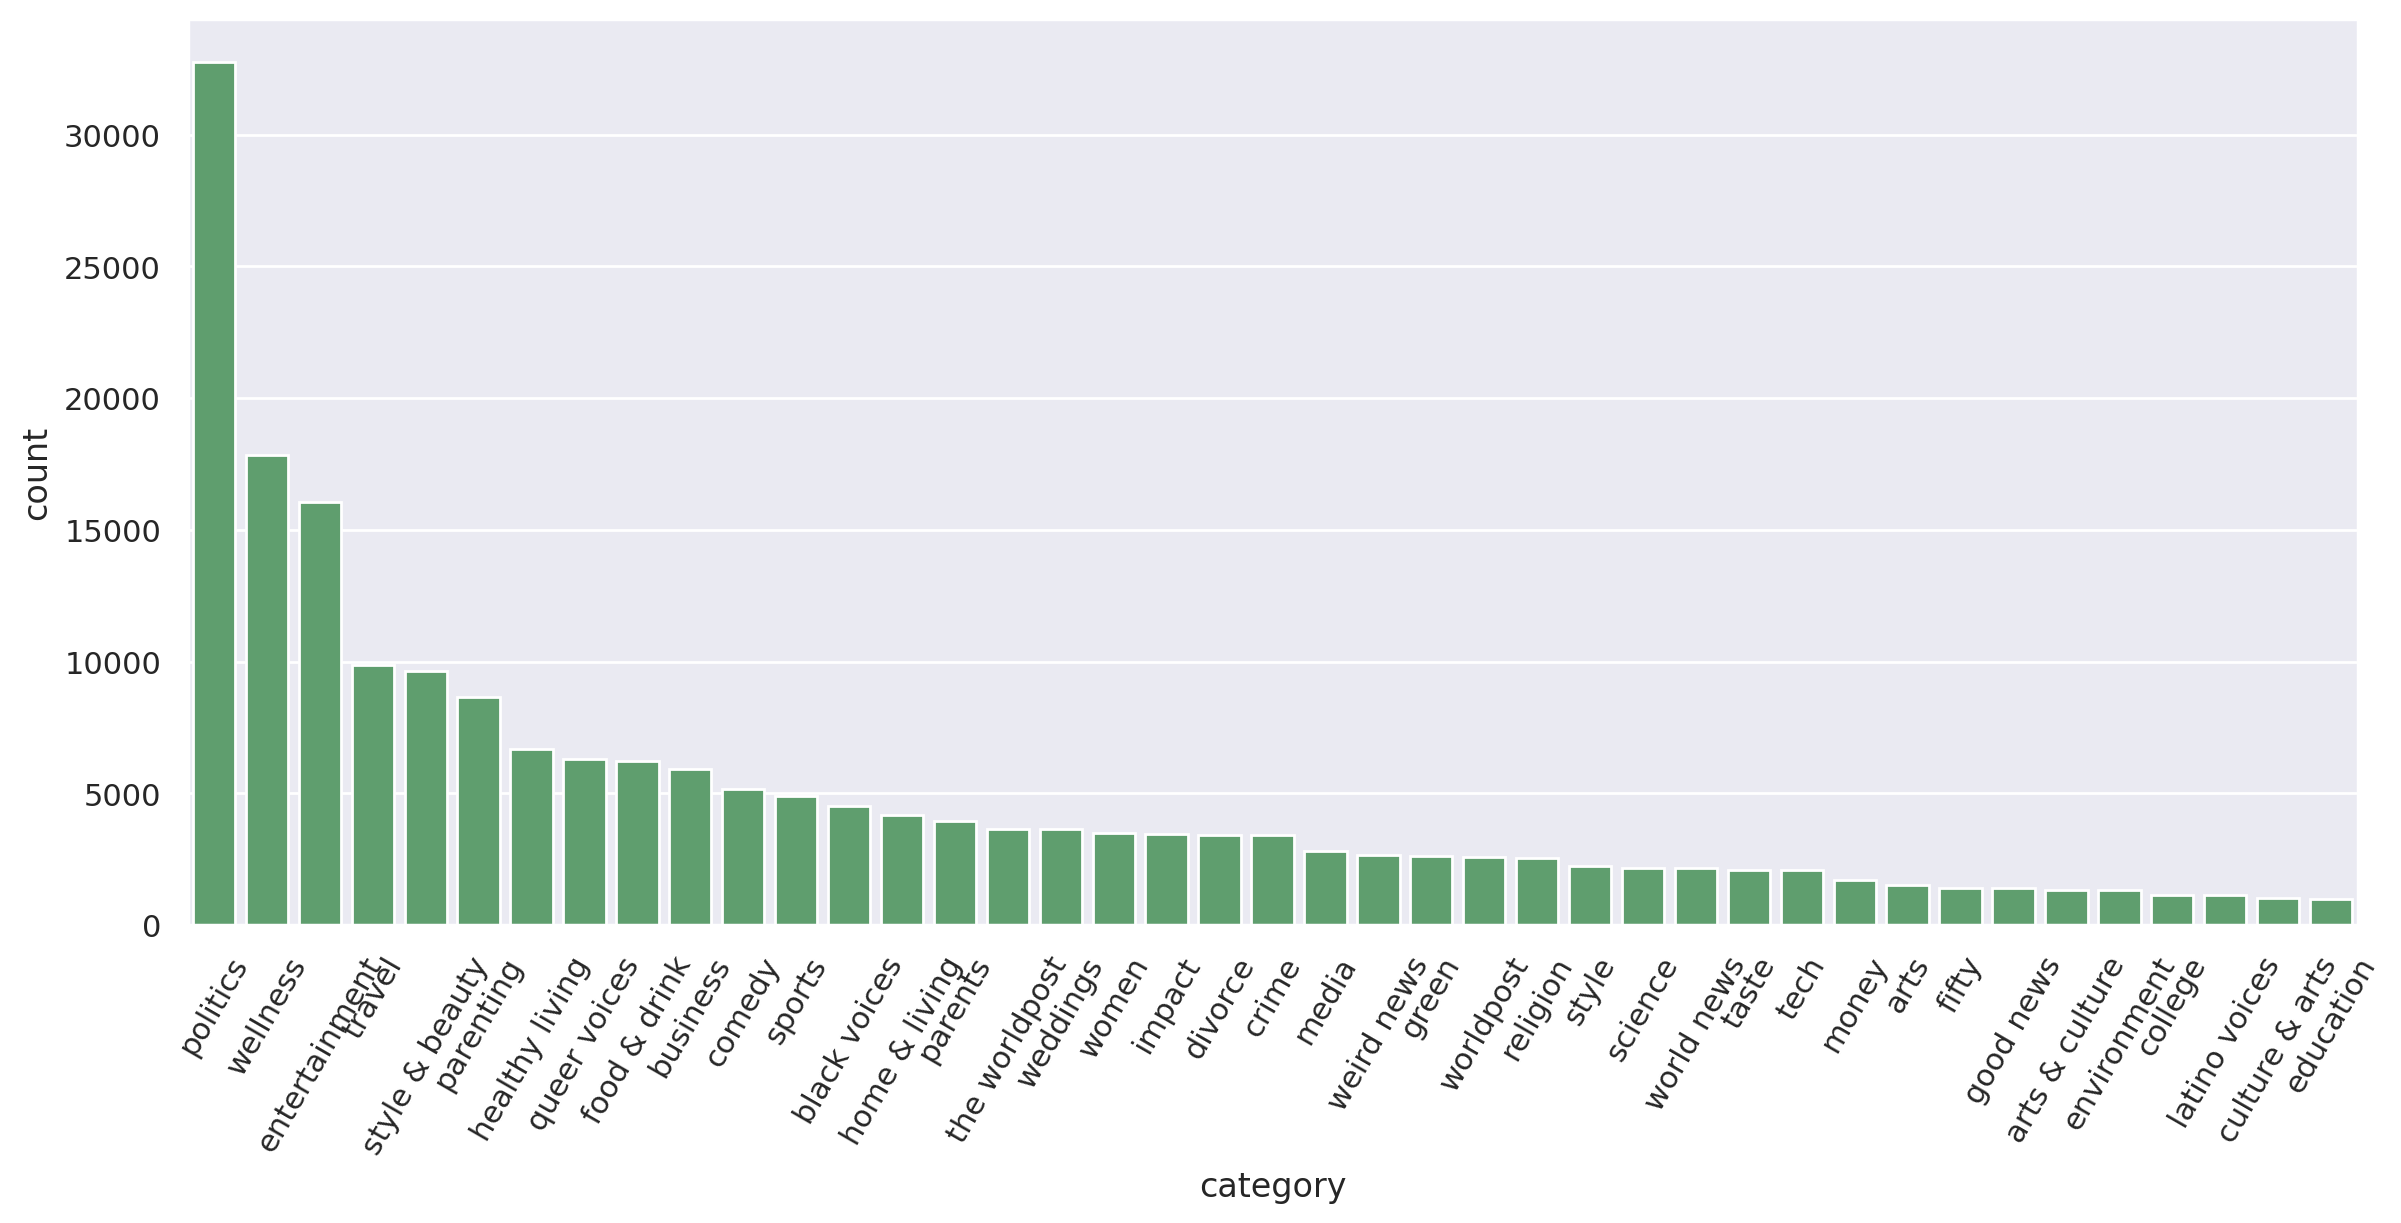

In [10]:
def bar_plot_cat(df):
    x = pd.DataFrame(df['category'].value_counts()).reset_index()
    x.rename(columns={'index':'category','category':"count"},inplace=True)
    fig, ax = plt.subplots(1,1,figsize=(14,6),dpi=(200))
    sns.barplot(data=x, x= 'category',y = 'count', color ='g');
    plt.xticks(rotation = 60);

bar_plot_cat(df)

### we could see a problem with these categories - there are many duplicates:
#### for example: "arts & calture" vs "culture & arts" or "parenting" vs "parents" or "style" vs "style and beauty" etc.
#### so we will reduce the number of categories and work just on them.
#### we see too that we have unbalanced data.



In [11]:
df_reduced = df[df['category'].isin(['politics','entertainment','travel','style & beauty','parenting',
                                     'food & drink','sports','buisness','tech','wellness'])].reset_index(drop=True)


In [12]:
df_reduced.shape

(108029, 2)

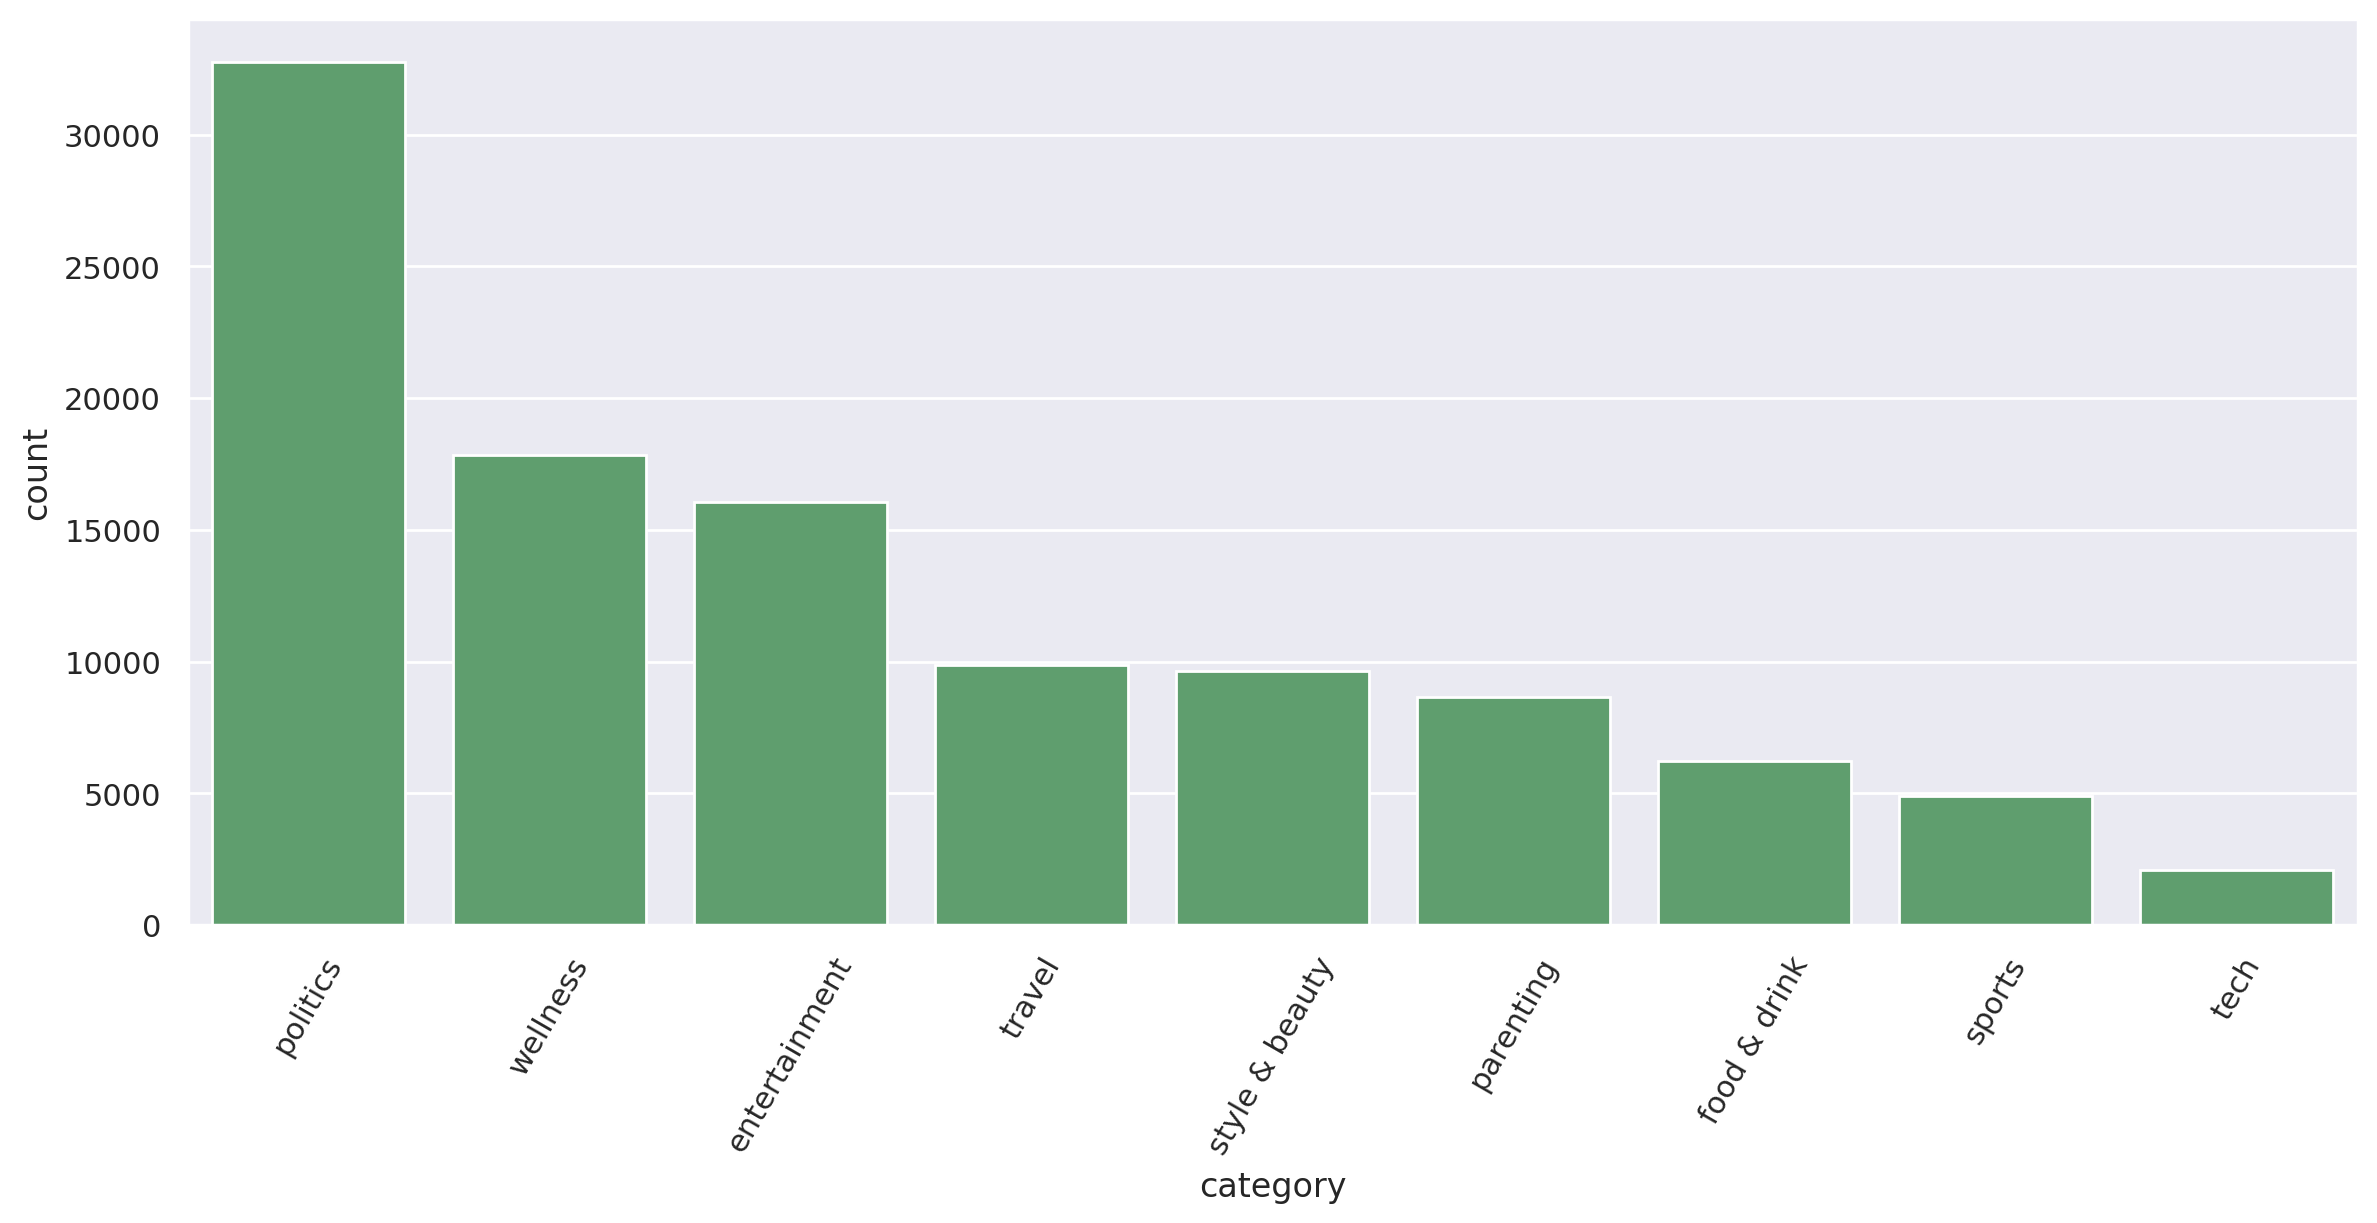

In [13]:
bar_plot_cat(df_reduced)

**a function to pre-process the text:**

In [14]:
%%time
# this is a function from gensim libarary which doing preprocess to to every string:
df_reduced["text_clean"] = df_reduced["text"].apply(lambda x: " ".join(preprocess_string(x)))

CPU times: user 27.5 s, sys: 30 ms, total: 27.6 s
Wall time: 27.6 s


In [15]:
df_reduced.head()

,category,text,text_clean
0,entertainment,will smith joins diplo and nicky jam for the 2...,smith join diplo nicki jam world cup offici so...
1,entertainment,hugh grant marries for the first time at age 5...,hugh grant marri time ag actor longtim girlfri...
2,entertainment,jim carrey blasts 'castrato' adam schiff and d...,jim carrei blast castrato adam schiff democrat...
3,entertainment,julianna margulies uses donald trump poop bags...,julianna marguli us donald trump poop bag pick...
4,entertainment,morgan freeman 'devastated' that sexual harass...,morgan freeman devast sexual harass claim unde...


In [16]:
for i in range(3):
    print('before:',df_reduced['text'].iloc[i])
    print('after:',df_reduced['text_clean'].iloc[i])
    print("------------------------------------------------------------------------------------------")

before: will smith joins diplo and nicky jam for the 2018 world cup's official song of course it has a song.
after: smith join diplo nicki jam world cup offici song cours song
------------------------------------------------------------------------------------------
before: hugh grant marries for the first time at age 57 the actor and his longtime girlfriend anna eberstein tied the knot in a civil ceremony.
after: hugh grant marri time ag actor longtim girlfriend anna eberstein ti knot civil ceremoni
------------------------------------------------------------------------------------------
before: jim carrey blasts 'castrato' adam schiff and democrats in new artwork the actor gives dems an ass-kicking for not fighting hard enough against donald trump.
after: jim carrei blast castrato adam schiff democrat new artwork actor give dem ass kick fight hard donald trump
------------------------------------------------------------------------------------------


**## Models**

**TF-IDF WITH NAIVE BAYES CLASSIFIER**

TF-IDF is a short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.
![definition](https://miro.medium.com/max/1400/1*NzTKUS0puSpmopsQzt6HRw.png)
![image](https://miro.medium.com/max/1400/1*HZvxT29V9B4HxT2wx8M4XQ.png)
the images are from [here.](https://medium.com/codex/document-indexing-using-tf-idf-189afd04a9fc)

In [17]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = df_reduced['text_clean']
y = df_reduced['category']
le =  LabelEncoder()
y = le.fit_transform(y)
classes = le.classes_
classes

array(['entertainment', 'food & drink', 'parenting', 'politics', 'sports',
       'style & beauty', 'tech', 'travel', 'wellness'], dtype=object)

In [18]:
X.shape, y.shape

((108029,), (108029,))

In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((75620,), (75620,), (32409,), (32409,))

**we will use a kind of naive bayes classifier to model our data**
naive bayes is commonly applied to text classification.
we actually use bayes theorm, to apply classification tasks, by this formula:

![naive bayes](http://shatterline.com/blog/wp-content/uploads/2013/09/bayes-pictorial5.png)
the image from <a href="http://shatterline.com/blog/">here</a>.
* naive bayes assume independence assumption which isnt true in the case of words, but in practice it works. 

In [21]:
## pipeline
classifier = MultinomialNB()
# we could add SMOTE to treat the imbalanced data - i saw it doesnt make here a difference.
# smt = SMOTE(random_state=42)
# model = Pipeline([("vectorizer", vectorizer),('sm',smt),("classifier", classifier)])

model = Pipeline([("vectorizer", vectorizer),("classifier", classifier)])
## train classifier
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('classifier', MultinomialNB())])

In [22]:
# we could see here the words count:
# dic_vocabulary = vectorizer.vocabulary_
# dic_vocabulary

In [23]:
y_pred = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [24]:
accuracy = metrics.accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
f1 = metrics.f1_score(y_test, y_pred,average='micro')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Micro f1:",round(f1,2))
print("Detail:")
print(metrics.classification_report(y_test, y_pred))
    

Accuracy: 0.82
Auc: 0.97
Micro f1: 0.82
Detail:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4802
           1       0.85      0.73      0.78      1869
           2       0.82      0.61      0.70      2596
           3       0.86      0.95      0.90      9842
           4       0.88      0.56      0.69      1514
           5       0.90      0.78      0.84      2814
           6       0.93      0.18      0.30       642
           7       0.81      0.80      0.80      3008
           8       0.72      0.89      0.80      5322

    accuracy                           0.82     32409
   macro avg       0.84      0.70      0.74     32409
weighted avg       0.83      0.82      0.81     32409



* **Precision is a measure of the ability of a classification model to identify only the relevant datapoints, while recall is a measure of the ability of a model to find all the relevant cases within a dataset. the f1 is the harmonic mean of both.**
* **i think that because we deal with posts which could be ambivalent, these outcomes are good even it isnt a very complicated model**
* **the macro avg is the avg of all the "precisions" for example, is to calculate the precision to every class, and then get the avg.** 
* **the micro avg for precision is to add all the TP and divide it by (all TP + all FP) like calculate precision to all the classes together.** 
* **in a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (like in our case).**
* **we have micro f1 of 0.82, and it's good for our task**



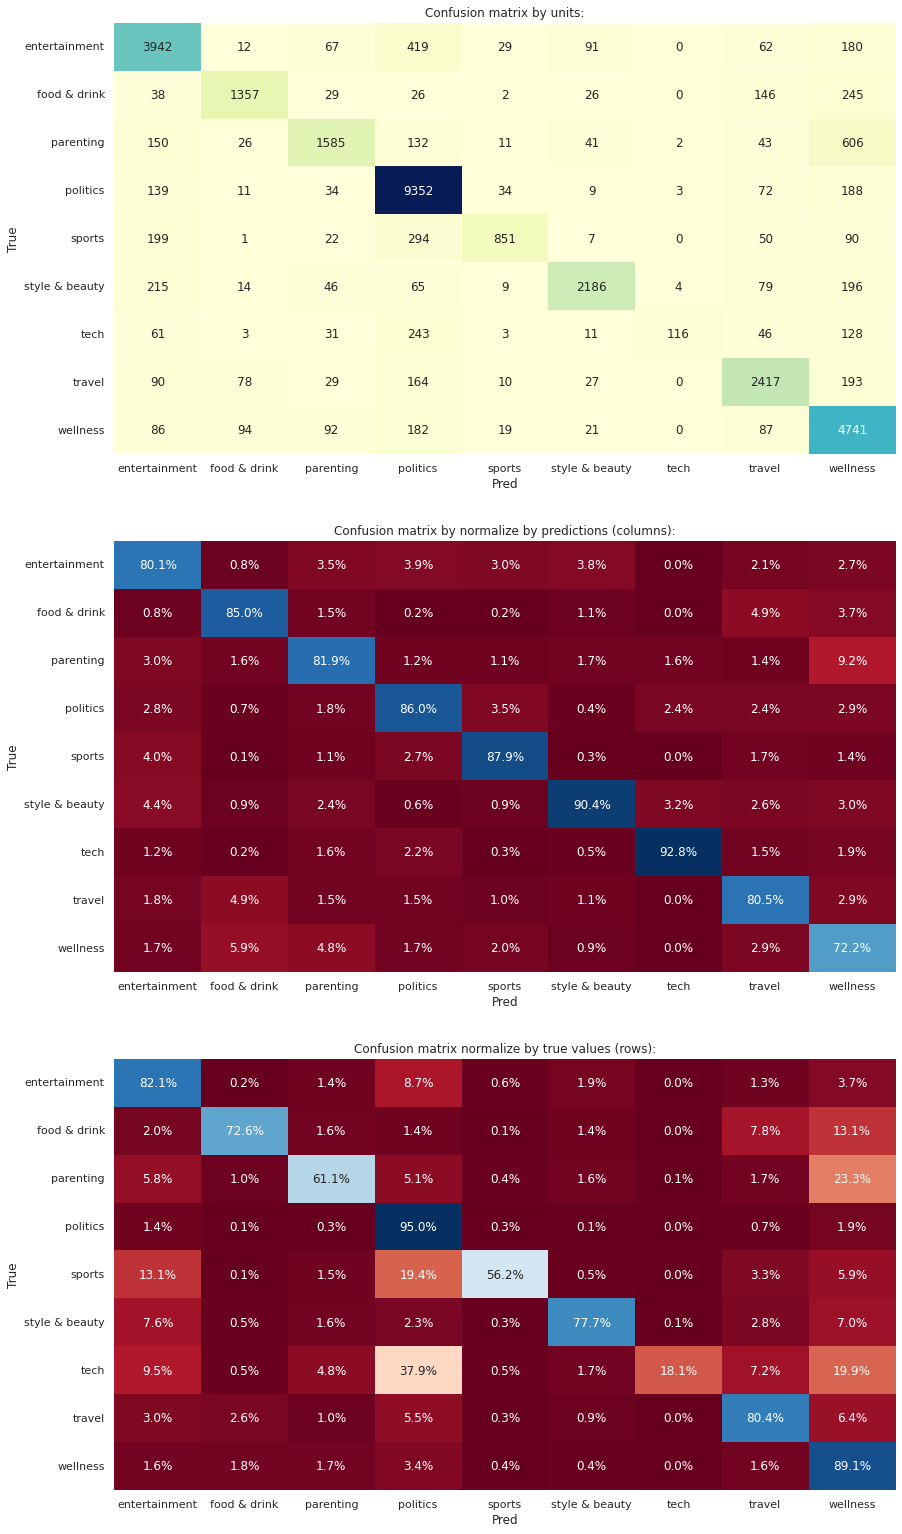

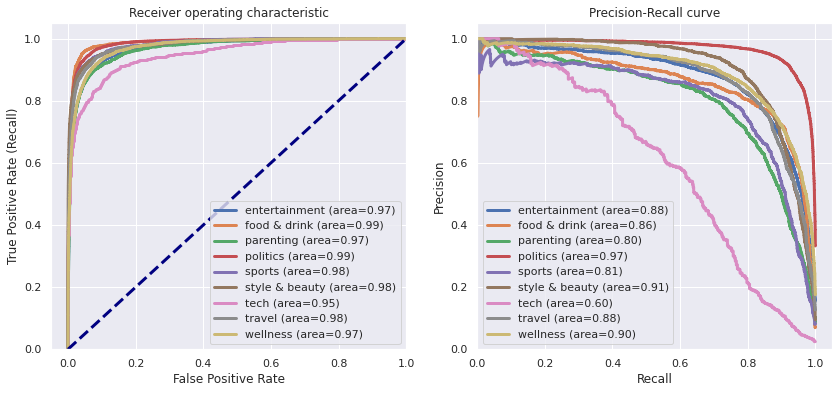

In [25]:

## Plot confusion matrix
fig, ax = plt.subplots(3,1,figsize=(14,27))

cm = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", ax=ax[0], cmap="YlGnBu", 
            cbar=False);
ax[0].set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
# plt.yticks(rotation=0);
ax[0].set_yticklabels(ax[0].get_xticklabels(),rotation = 0)
ax[0].set_title("Confusion matrix by units:")



cm = metrics.confusion_matrix(y_test, y_pred,normalize='pred')
sns.heatmap(cm, annot=True, fmt=".1%", ax=ax[1], cmap="RdBu", 
            cbar=False);
ax[1].set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
# plt.yticks(rotation=0);
ax[1].set_yticklabels(ax[0].get_xticklabels(),rotation = 0)
ax[1].set_title("Confusion matrix by normalize by predictions (columns):")

cm = metrics.confusion_matrix(y_test, y_pred,normalize='true')
sns.heatmap(cm, annot=True, fmt=".1%", ax=ax[2], cmap="RdBu", 
            cbar=False);
ax[2].set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
# plt.yticks(rotation=0);
ax[2].set_yticklabels(ax[1].get_xticklabels(),rotation = 0)
ax[2].set_title("Confusion matrix normalize by true values (rows):")

# Plot roc
# the functions get the form of "label binarize" - [0,0,1,0,0], so we first 
# transform y_test and y_pred to this shape:
y_test_bin = label_binarize(y_test, classes = le.transform(classes))
y_pred_bin = label_binarize(y_pred, classes = le.transform(classes))

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_bin[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_bin[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)




# Conclusions
    * the general accuracy and the micro f1 are both 0.82, it's good result for this mission (because we deal with text that could belong to more than one class, and the implications of mistakes in this classification are not serious.
    * we could see in the heatmap that there are more ambligous categories, like politics - we have predicted to politics many news that belongs to other categories (we could try to increase the threshold of "politics" category).
    * we could see too that there are some bright squares not in the diagonal. these squares are the places that the categories are ambligous. for example - the square of "parenting - wellness" is ambligous.
    * we could see a very interesting thing in the Tech columns - 
        we predicted 92% of the tech posts correctly and signed them as tech (92% precision)
        but in the real values (recall) ? only 18%!
        that say that the model has attitude to predict "Tech" even on things which are not "Tech"! if we increase the threshold of predicting "Tech" maybe it would be better.
    * the cons of the method we have used, TF-IDF vector, is that every word gets a value that not in her context. if we want more accurate and more complex model, we should consider models like BERT or Word2Vec. but as we said, for posts calassification, 0.86 accuracy and microf1 are good result.
# Recommendations:
    * my recommendation is to unite some of the categories in the original dataset. there are many duplicate and ambligous categories in the original DataSet - that makes the classification harder. we should decide what categories are realy necessery and classify all the posts only to these categories.
    